In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import numpy as np
from typing import NamedTuple
from plyfile import PlyData
import graphics_utils
import myfunctions
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torchvision

In [ ]:
# Load the ./data/poin_cloud.ply file (3dgs representation)

means, normals, opacitys, scales, rots, f_dcs, f_rests = myfunctions.loadply('./data/point_cloud.ply', requires_grad=False)
N = means.shape[0]
# N = 1
means    = means   [0:N]
normals  = normals [0:N]
opacitys = opacitys[0:N]
scales   = scales  [0:N]
rots     = rots    [0:N]
f_dcs    = f_dcs   [0:N]
f_rests  = f_rests [0:N]
print("means.shape", means.shape)
print("normals.shape", normals.shape)
print("opacitys.shape", opacitys.shape)
print("scales.shape", scales.shape)
print("rots.shape", rots.shape)
print("f_dcs.shape", f_dcs.shape)
print("f_rests.shape", f_rests.shape)





means.shape torch.Size([1, 3])
normals.shape torch.Size([1, 3])
opacitys.shape torch.Size([1, 1])
scales.shape torch.Size([1, 3])
rots.shape torch.Size([1, 4])
f_dcs.shape torch.Size([1, 1, 3])
f_rests.shape torch.Size([1, 15, 3])


In [3]:
# Camera
# data from /gaussain-splatting/data/output/cameras.json
position = [1.3136163323982164, -2.8528294530901546, 2.561592061938265]
rotation = [[-0.8281871789359426, -0.3082205363180619,  0.4680877029338959], 
            [0.26120334583680177,  0.5266721096512661,  0.8089433237496585], 
            [-0.49586168310304535, 0.7922225633666913, -0.3556748533744323]]
rotation = np.array(rotation).T
# The rotation matrix in cameras.json needs to be transposed to match the rotation matrix in the code
fy       = 600.1774500604101
fx       = 599.969888751631

In [4]:
# data from /gaussain-splatting/data/sparse/0/images.bin (COLMAP output)
QW, QX, QY, QZ = -0.29274992627705781, -0.01427904747544056, 0.82318499469463746, 0.48627158458783204 # unit quaternion
TX, TY, TZ     = 3.1032841540380889,   -0.12196179258629745, 2.6039835693399422
# data from /gaussain-splatting/data/sparse/0/cameras.bin (COLMAP output)
# 1 PINHOLE 1199 679 599.96988875163095 600.17745006041014 599.5 339.5
# CAMERA_ID, MODEL, WIDTH, HEIGHT, focal_length_x, focal_length_y, principal_point_x, principal_point_y
WIDTH, HEIGHT = 1199, 679
FX, FY = 599.96988875163095, 600.17745006041014
PX, PY = 599.5, 339.5


In [5]:
R = myfunctions.quaternion2rotation([QW, QX, QY, QZ]).T
T = np.array([TX, TY, TZ])

trans = np.array([.0, .0, .0])
scale = 1.0
zfar  = 100.0
znear = 0.001
FovY = graphics_utils.focal2fov(FY, HEIGHT)
FovX = graphics_utils.focal2fov(FX, WIDTH)
tanfovx = math.tan(FovX * 0.5)
tanfovy = math.tan(FovY * 0.5)
bg_color = torch.tensor([0., 0., 0.], device='cuda:0')
scaling_modifier = 1.0
active_sh_degree = 3
debug = False
antialiasing = False



world_view_transform = torch.tensor(graphics_utils.getWorld2View2(R, T, trans, scale)).transpose(0, 1).cuda()
projection_matrix = graphics_utils.getProjectionMatrix(znear=znear, zfar=zfar, fovX=FovX, fovY=FovY).transpose(0,1).cuda()
full_proj_transform = (world_view_transform.unsqueeze(0).bmm(projection_matrix.unsqueeze(0))).squeeze(0)
camera_center = world_view_transform.inverse()[3, :3]



print("world_view_transform:\n", world_view_transform)
print("projection_matrix:\n", projection_matrix)
print("full_proj_transform:\n", full_proj_transform)
print("camera_center:\n", camera_center)


# print("world_view_transform.shape", world_view_transform.shape)
# print("world_view_transform.dtype", world_view_transform.dtype)
# print("projection_matrix.shape", projection_matrix.shape)
# print("projection_matrix.dtype", projection_matrix.dtype)
# print("full_proj_transform.shape", full_proj_transform.shape)
# print("full_proj_transform.dtype", full_proj_transform.dtype)
# print("camera_center.shape", camera_center.shape)
# print("camera_center.dtype", camera_center.dtype)



world_view_transform:
 tensor([[-0.8282, -0.3082,  0.4681,  0.0000],
        [ 0.2612,  0.5267,  0.8089,  0.0000],
        [-0.4959,  0.7922, -0.3557,  0.0000],
        [ 3.1033, -0.1220,  2.6040,  1.0000]], device='cuda:0')
projection_matrix:
 tensor([[ 1.0008e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.7678e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.0000e-03,  0.0000e+00]], device='cuda:0')
full_proj_transform:
 tensor([[-0.8288, -0.5449,  0.4681,  0.4681],
        [ 0.2614,  0.9311,  0.8090,  0.8089],
        [-0.4963,  1.4005, -0.3557, -0.3557],
        [ 3.1057, -0.2156,  2.6030,  2.6040]], device='cuda:0')
camera_center:
 tensor([ 1.3136, -2.8528,  2.5616], device='cuda:0')


==================================================Forward pass
cov[0]: +89.1968 -3.1544 +14.7474

rotation_activation: 
 tensor([[ 0.9437, -0.1250,  0.2214, -0.2117]], device='cuda:0')
means3D.shape torch.Size([1, 3])
means3D.dtype torch.float32
means2D.shape torch.Size([1, 3])
means2D.dtype torch.float32
shs.shape torch.Size([1, 16, 3])
shs.dtype torch.float32
opacity.shape torch.Size([1, 1])
opacity.dtype torch.float32
scales.shape torch.Size([1, 3])
scales.dtype torch.float32
rotations.shape torch.Size([1, 4])
rotations.dtype torch.float32


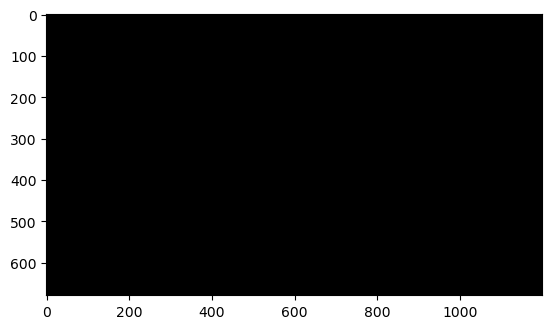

In [6]:
# render
screenspace_points = torch.zeros_like(means, dtype=means.dtype, requires_grad=False, device="cuda") + 0
raster_settings = GaussianRasterizationSettings(
    image_height=int(HEIGHT),
    image_width=int(WIDTH),
    tanfovx=tanfovx,
    tanfovy=tanfovy,
    bg=bg_color,
    scale_modifier=scaling_modifier,
    viewmatrix=world_view_transform,
    projmatrix=full_proj_transform,
    sh_degree=active_sh_degree,
    campos=camera_center,
    prefiltered=False,
    debug=debug,
    antialiasing=antialiasing
)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)
means3D = means
means2D = screenspace_points
opacity = torch.sigmoid(opacitys)
scales = torch.exp(scales)
# rotations = rots
rotations = torch.nn.functional.normalize(rots)
shs = torch.cat((f_dcs, f_rests), dim=1)
rendered_image, radii, depth_image = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = shs,
    colors_precomp = None,
    opacities = opacity,
    scales = scales,
    rotations = rotations,
    cov3D_precomp = None)

print("=" * 50)
print("rotation_activation: \n", rotations)

print("means3D.shape", means3D.shape)
print("means3D.dtype", means3D.dtype)
print("means2D.shape", means2D.shape)
print("means2D.dtype", means2D.dtype)
print("shs.shape", shs.shape)
print("shs.dtype", shs.dtype)
print("opacity.shape", opacity.shape)
print("opacity.dtype", opacity.dtype)
print("scales.shape", scales.shape)
print("scales.dtype", scales.dtype)
print("rotations.shape", rotations.shape)
print("rotations.dtype", rotations.dtype)

out = {
    "render": rendered_image,
    "viewspace_points": screenspace_points,
    "visibility_filter" : (radii > 0).nonzero(),
    "radii": radii,
    "depth" : depth_image
}
rendering = out["render"]
torchvision.utils.save_image(rendering, "rendered_image.png")

# show the rendered image
final_image = rendering.cpu().detach().numpy().transpose(1, 2, 0)
plt.imshow(final_image)






In [ ]:
# print("means.shape", means.shape)
# print("full_proj_transform.shape", full_proj_transform.shape)
# print("means:", means)
# print("full_proj_transform:", full_proj_transform)

# cuuling, p_view, mean2D = myfunctions.cull_and_project_point(mean3D=means, projmatrix=full_proj_transform, viewmatrix=world_view_transform)
# print("cuuling:", cuuling)
# print("p_view:", p_view)
# print("mean2D:", mean2D)


# project_points(means, normals, opacitys, scales, rots, f_dcs, f_rests, projmatrix, viewmatrix):
# myfunctions.project_points(means=means, normals=normals, opacitys=opacitys, scales=scales, rots=rotations, f_dcs=f_dcs, f_rests=f_rests, projmatrix=full_proj_transform, viewmatrix=world_view_transform)
# def project_points(means, normals, opacitys, scales, rots, f_dcs, f_rests, projmatrix, viewmatrix, focal_x, focal_y, tan_fovx, tan_fovy):

# myfunctions.project_points(means=means, normals=normals, opacitys=opacitys, scales=scales, rots=rotations, f_dcs=f_dcs, f_rests=f_rests, projmatrix=full_proj_transform, viewmatrix=world_view_transform, focal_x=fx, focal_y=fy, tan_fovx=tanfovx, tan_fovy=tanfovy)



means.shape torch.Size([1, 3])
full_proj_transform.shape torch.Size([4, 4])
means: tensor([[ 6.5382, -0.7929,  3.6458]], device='cuda:0')
full_proj_transform: tensor([[-0.8288, -0.5449,  0.4681,  0.4681],
        [ 0.2614,  0.9311,  0.8090,  0.8089],
        [-0.4963,  1.4005, -0.3557, -0.3557],
        [ 3.1057, -0.2156,  2.6030,  2.6040]], device='cuda:0')
conv2D:  tensor([[89.1968, -3.1544, 14.7474]], device='cuda:0')
